In [1]:
!pip install fasttext scikit-learn pandas imbalanced-learn --quiet

import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
fasttext.util.download_model('pl', if_exists='ignore')

'cc.pl.300.bin'

In [3]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [4]:
def get_ft_vector(text):
    return ft_model.get_sentence_vector(text)

In [ ]:
def prepare_data(train_path, test_path, smote=True):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train = np.vstack(train_df['text'].apply(get_ft_vector))
    y_train = train_df['label'].values
    X_test = np.vstack(test_df['text'].apply(get_ft_vector))
    y_test = test_df['label'].values

    if smote:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class distribution in train after SMOTE: {np.bincount(y_train)}")

    return X_train, y_train, X_test, y_test

In [ ]:
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, param_grid, model_name="knn_model", verbose=2):
    knn = KNeighborsClassifier()
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=verbose
    )

    print("Start strojenia hiperparametrów...")
    grid_search.fit(X_train, y_train)

    print("\nNajlepsze parametry:", grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    best_knn = grid_search.best_estimator_

    y_pred = best_knn.predict(X_test)

    if hasattr(best_knn, "predict_proba"):
        y_proba = best_knn.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print("\n=== Evaluation Metrics (Final Model on Test Set) ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    else:
        print("ROC-AUC:   brak możliwości obliczenia (brak predict_proba)")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    os.makedirs("KNN_results", exist_ok=True)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for KNN - The Best Variant")
    plt.savefig(f"KNN_results/{model_name}_confusion_matrix.png")
    plt.show()

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title("ROC Curve for KNN - The Best Varian")
        plt.savefig(f"KNN_results/{model_name}_roc_curve.png")
        plt.show()

    joblib.dump(best_knn, f"KNN_results/{model_name}.joblib")
    print(f"Model zapisany jako: KNN_results/{model_name}.joblib")

In [7]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11, 15, 21],
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan']
}

In [8]:
def run_pipeline_knn(train_path, test_path, smote=True, param_grid=param_grid_knn):
    X_train, y_train, X_test, y_test = prepare_data(train_path, test_path, smote=smote)
    train_and_evaluate_knn(X_train, y_train, X_test, y_test, param_grid)

Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 12 candidates, totalling 48 fits

Najlepsze parametry: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.7369

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.3810
Precision: 0.1745
Recall:    0.9701
F1-score:  0.2958
ROC-AUC:   0.6955

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.29      0.45       866
           1       0.17      0.97      0.30       134

    accuracy                           0.38      1000
   macro avg       0.58      0.63      0.37      1000
weighted avg       0.88      0.38      0.43      1000



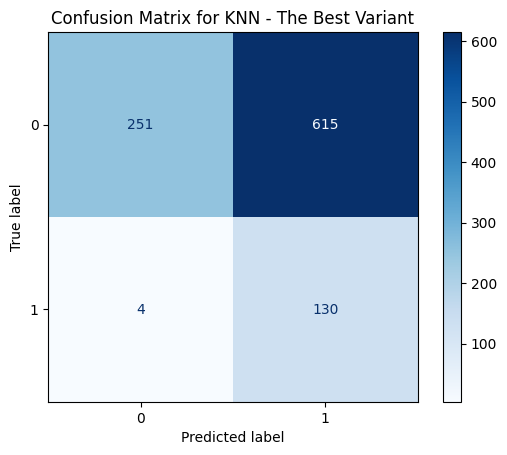

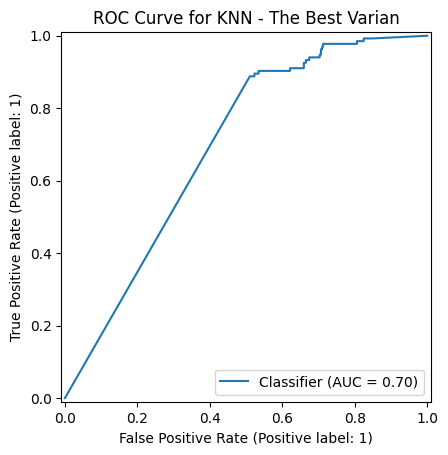

Model zapisany jako: KNN_results/knn_model.joblib


In [29]:
run_pipeline_knn("v1_training_variant1_raw.csv", "v1_test_variant1_raw.csv", smote=True)

Train shape: (10041, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190  851]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 12 candidates, totalling 48 fits

Najlepsze parametry: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.4048

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8600
Precision: 0.4375
Recall:    0.1567
F1-score:  0.2308
ROC-AUC:   0.6895

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       866
           1       0.44      0.16      0.23       134

    accuracy                           0.86      1000
   macro avg       0.66      0.56      0.58      1000
weighted avg       0.82      0.86      0.83      1000



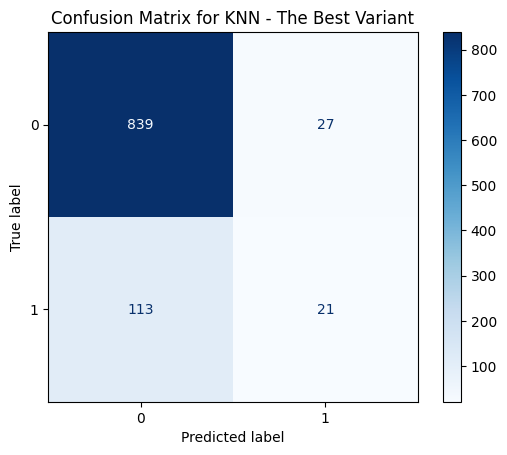

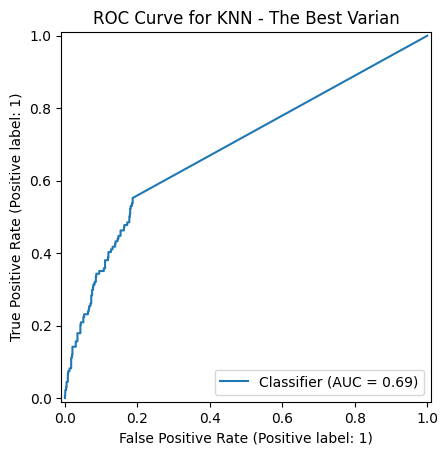

Model zapisany jako: KNN_results/knn_model.joblib


In [30]:
run_pipeline_knn("v1_training_variant1_raw.csv", "v1_test_variant1_raw.csv", smote=False)

Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 12 candidates, totalling 48 fits

Najlepsze parametry: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.7649

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.4530
Precision: 0.1885
Recall:    0.9328
F1-score:  0.3137
ROC-AUC:   0.7175

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.38      0.55       866
           1       0.19      0.93      0.31       134

    accuracy                           0.45      1000
   macro avg       0.58      0.66      0.43      1000
weighted avg       0.87      0.45      0.51      1000



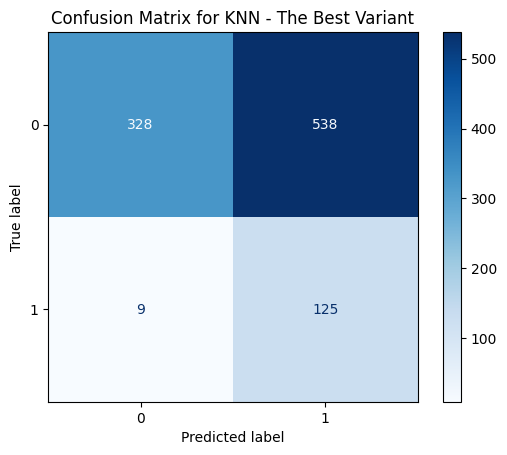

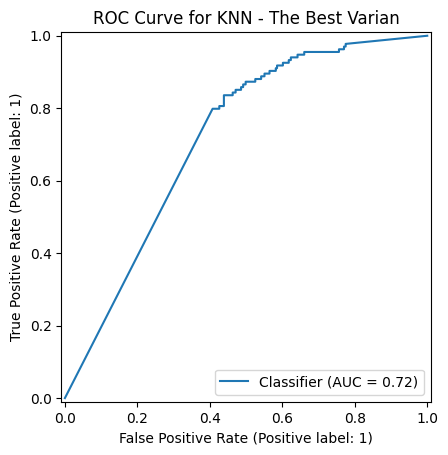

Model zapisany jako: KNN_results/knn_model.joblib


In [31]:
run_pipeline_knn("v1_training_variant2_light.csv", "v1_test_variant2_light.csv", smote=True)

Train shape: (10041, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190  851]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 12 candidates, totalling 48 fits

Najlepsze parametry: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.4073

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8700
Precision: 0.5400
Recall:    0.2015
F1-score:  0.2935
ROC-AUC:   0.6663

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       866
           1       0.54      0.20      0.29       134

    accuracy                           0.87      1000
   macro avg       0.71      0.59      0.61      1000
weighted avg       0.84      0.87      0.84      1000



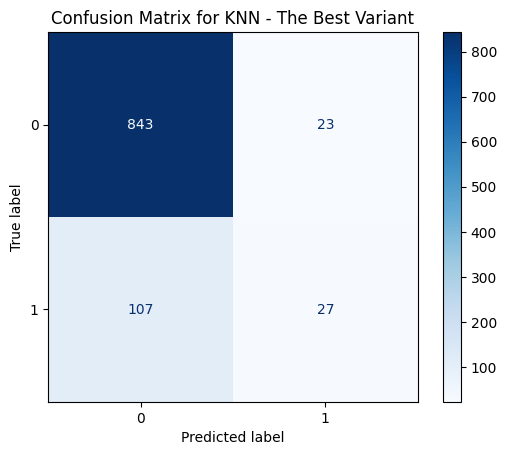

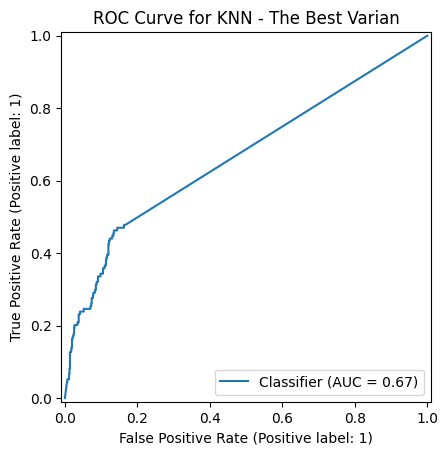

Model zapisany jako: KNN_results/knn_model.joblib


In [32]:
run_pipeline_knn("v1_training_variant2_light.csv", "v1_test_variant2_light.csv", smote=False)

Train shape: (18314, 300), Test shape: (999, 300)
Class distribution in train after SMOTE: [9157 9157]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 12 candidates, totalling 48 fits

Najlepsze parametry: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.7814

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.5065
Precision: 0.2023
Recall:    0.9104
F1-score:  0.3311
ROC-AUC:   0.7233

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.44      0.61       865
           1       0.20      0.91      0.33       134

    accuracy                           0.51       999
   macro avg       0.59      0.68      0.47       999
weighted avg       0.87      0.51      0.57       999



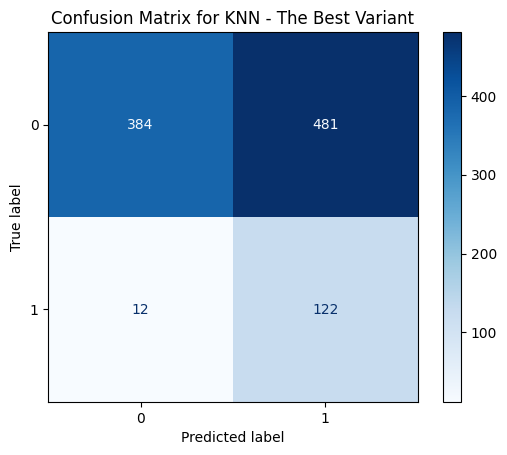

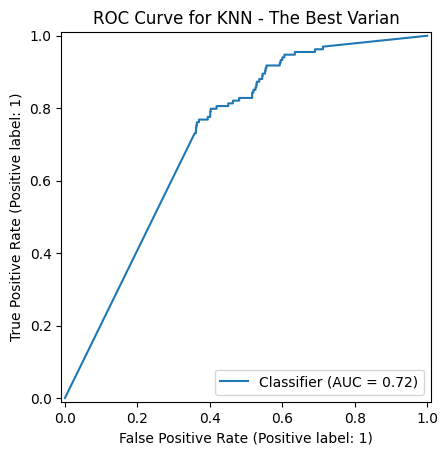

Model zapisany jako: KNN_results/knn_model.joblib


In [33]:
run_pipeline_knn("v1_training_variant3_full.csv", "v1_test_variant3_full.csv", smote=True)

Train shape: (10008, 300), Test shape: (999, 300)
Class distribution in train after SMOTE: [9157  851]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 12 candidates, totalling 48 fits

Najlepsze parametry: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.3802

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8599
Precision: 0.4500
Recall:    0.2015
F1-score:  0.2784
ROC-AUC:   0.6986

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       865
           1       0.45      0.20      0.28       134

    accuracy                           0.86       999
   macro avg       0.67      0.58      0.60       999
weighted avg       0.83      0.86      0.84       999



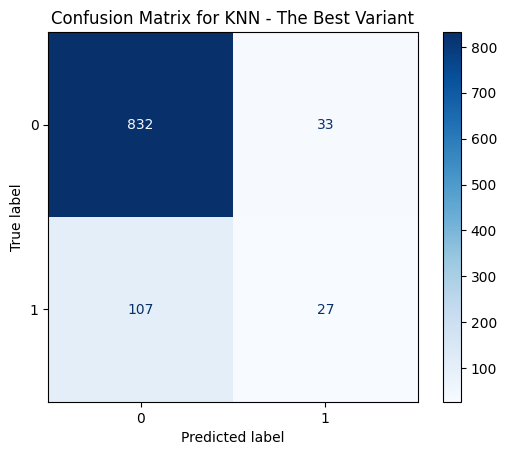

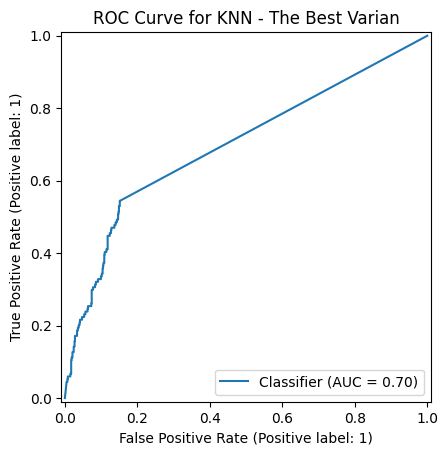

Model zapisany jako: KNN_results/knn_model.joblib


In [34]:
run_pipeline_knn("v1_training_variant3_full.csv", "v1_test_variant3_full.csv", smote=False)